# Teams EDA and Feature selection process

Insights from here will be used to build prediction model on match winning probability.


# EDA & Feature Selection

## Import libraries

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
import pandas as pd
from numpy.random import randn
from numpy.random import seed
import warnings
import numpy as np
import pandas as pd
import scipy
import scipy.stats as st
import statsmodels as sm
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder
from collections import Counter, OrderedDict
from itertools import combinations
import pandas_profiling as pp

from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler


## Read cleaned data

In [0]:
# Teams version 3 data (Cleaned but full features) 
link = 'https://drive.google.com/open?id=1Af-3N2ZUiyfgpWfp-Fqer9dwDus8ZzB7'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Teams_v3.csv')  
Teams_df = pd.read_csv('Teams_v3.csv')

In [0]:
Teams_df = Teams_df.drop(['level_0','index'],axis=1) #drop extra index from the csv
Teams_df.head()

,gameid,league,ban1,ban2,ban3,ban4,ban5,result,kpm,d,a,fb,fbvictim,fbtime,fd,fdtime,teamdragkills,elementals,firedrakes,waterdrakes,earthdrakes,airdrakes,elders,herald,heraldtime,ft,fttime,firstmidouter,firsttothreetowers,teamtowerkills,fbaron,fbarontime,teambaronkills,dmgtochamps,wards,wardshare,wardkills,wcpm,visionwards,visiblewardclearrate,invisiblewardclearrate,goldspent,minionkills,monsterkillsenemyjungle,goldat10,goldat15,xpat10,gdiffat10,gdiffat15
0,1002300127,NALCS,LeBlanc,Zac,Shen,Tristana,Kog'Maw,0,0.118188,18.0,2.0,1,0,6.732133,0,11.941800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,14.088500,1.0,12.368267,0.0,0.0,4.0,0.0,21.536467,0.0,32359.0,76.0,1.0,18.0,0.709127,24.0,0.571429,0.037037,39530.0,691.0,5.0,14949.0,23007.0,18625.0,-342.0,-3854.0
1,1002300127,NALCS,Caitlyn,Kalista,Thresh,Blitzcrank,Bard,1,0.709127,3.0,55.0,0,1,6.732133,1,11.941800,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,14.088500,0.0,12.368267,1.0,1.0,10.0,1.0,21.536467,1.0,54497.0,82.0,1.0,27.0,1.063690,25.0,0.653846,0.200000,45160.0,693.0,18.0,15291.0,26861.0,18807.0,342.0,3854.0
2,240145,NACS,Elise,Caitlyn,Thresh,Vladimir,Brand,1,0.554734,28.0,64.0,1,0,6.532150,0,16.393367,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,13.826250,0.0,14.792250,1.0,0.0,10.0,0.0,23.230017,2.0,142669.0,134.0,1.0,36.0,0.798817,23.0,0.538462,0.147059,80035.0,1117.0,82.0,14972.0,23524.0,17739.0,-79.0,-1283.0
3,240145,NACS,Zac,Cassiopeia,Nunu,Tristana,Viktor,0,0.621302,25.0,72.0,0,1,6.532150,1,16.393367,3.0,3.0,1.0,0.0,0.0,2.0,0.0,1.0,13.826250,1.0,14.792250,0.0,1.0,6.0,1.0,23.230017,1.0,139501.0,141.0,1.0,52.0,1.153846,33.0,0.658537,0.268817,77850.0,1080.0,82.0,15051.0,24807.0,18289.0,79.0,1283.0
4,240148,NACS,Cassiopeia,Sejuani,Blitzcrank,Lucian,Viktor,1,0.784314,2.0,35.0,1,0,5.728883,1,12.597450,2.0,2.0,0.0,0.0,1.0,1.0,0.0,1.0,16.359083,1.0,7.878567,1.0,1.0,10.0,1.0,20.965183,1.0,50721.0,68.0,1.0,14.0,0.610022,11.0,0.733333,0.071429,42430.0,665.0,33.0,17010.0,27395.0,19356.0,2154.0,4830.0


There are 51 variables in this dataset. Note: gameid is not unique. 

## Exploring data at high level



There are 5443 matches in the data for period of 2017-2019.

In [0]:
# check if data is balanced
win = Teams_df[Teams_df['result'] == 1]
loss = Teams_df[Teams_df['result'] == 0]
print(win.shape)
print(loss.shape)

(5443, 49)
(5443, 49)


This dataset is balanced with equal number of wins and loss. 

In [0]:
# check % win of blue/red team. 
blue = round(np.mean(Teams_df['result'][::2])*100,2)
red = round(np.mean(Teams_df['result'][1::2])*100,2)
rslt = [blue,red]
pd.DataFrame({'% Win': rslt},index = ['Blue','Red'])

,% Win
Blue,54.55
Red,45.45


Blue teams have higher winning percentage compare to red teams. It may be due to the fact that blue teams get to choose their champions first. 

In [0]:
# Find and plot the top 30 champions in round 1 banning(ban1,ban2,ban3)
# Since three champions are banned during the first round without any prior info(eg.component previous picks) only based on team preferences, 
# it is reasonable to look at ban1 ban2 and ban3 as a whole. 

r1 = Counter(list(Teams_df['ban1']) + list(Teams_df['ban2']) + list(Teams_df['ban3']))
sorted_ban1_2_3 = pd.DataFrame(list((r1.most_common()))[0:30],columns = ['Champion','Count'])
sorted_ban1_2_3.head(20)


,Champion,Count
0,Galio,1186
1,Camille,1071
2,LeBlanc,1009
3,Aatrox,973
4,Kalista,972
5,Taliyah,954
6,Zac,942
7,Zoe,874
8,Ryze,846
9,Rakan,819


The table above shows the top 30 heroes banned by gamers. Since three champions are banned during the first round without any prior info(eg.component previous picks) only based on team preferences, it is reasonable to look at ban1 ban2 and ban3 as a whole.

Text(0.5, 1.0, 'League and match results')

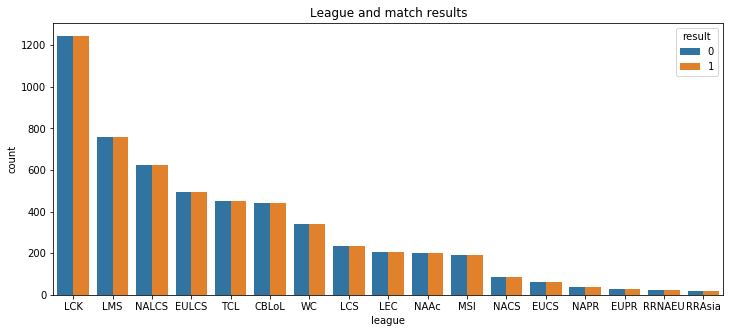

In [0]:
# Check # of games played by leagues
# Check also win-loss ratio of league games, it should be 1:1
plt.figure(figsize=(12,5))
ax=plt.axes()
sns.countplot(x="league", hue="result",
              data=Teams_df, order= Teams_df['league'].value_counts().index,ax=ax)
ax.set_title('League and match results')

From the plot above, it shows LCK is the league that participates most often. 

No handles with labels found to put in legend.


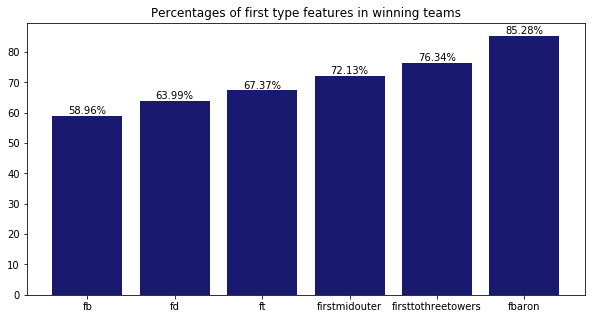

In [0]:
p_ft = Teams_df[(Teams_df['ft']==1) & (Teams_df['result'] == 1)].count()/Teams_df[Teams_df['result']==1].count()
p_firstmidouter = Teams_df[(Teams_df['firstmidouter']==1) & (Teams_df['result'] == 1)].count()/Teams_df[Teams_df['result']==1].count()
p_firsttothreetowers = Teams_df[(Teams_df['firsttothreetowers']==1) & (Teams_df['result'] == 1)].count()/Teams_df[Teams_df['result']==1].count()
p_fbaron = Teams_df[(Teams_df['fbaron']==1) & (Teams_df['result'] == 1)].count()/Teams_df[Teams_df['result']==1].count()
p_fd = Teams_df[(Teams_df['fd']==1) & (Teams_df['result'] == 1)].count()/Teams_df[Teams_df['result']==1].count()
p_fb = Teams_df[(Teams_df['fb']==1) & (Teams_df['result'] == 1)].count()/Teams_df[Teams_df['result']==1].count()
percentages_first = [(p_ft[1])*100,(p_firstmidouter[1])*100,(p_firsttothreetowers[1])*100,(p_fbaron[1])*100,(p_fd[1])*100,(p_fb[1])*100]
label = ['ft', 'firstmidouter', 'firsttothreetowers','fbaron','fd','fb']
label = [x for _,x in sorted(zip(percentages_first,label))]

plt.figure(figsize=(10,5))
plt.bar(label,sorted(percentages_first),color = 'midnightblue')
plt.legend().remove()
for a,b in zip(np.arange(len(label)), sorted(percentages_first)):
    plt.text(a, b, '%.2f'%b+'%', ha='center', va= 'bottom',fontsize=10)
plt.title('Percentages of first type features in winning teams')
plt.show()

This plot shows the importance of having first type features for winning a game. It seems like fbaron is the most important one followed by firsttothreetowers and firstmidouter.

Text(0.5, 1, 'Game length')

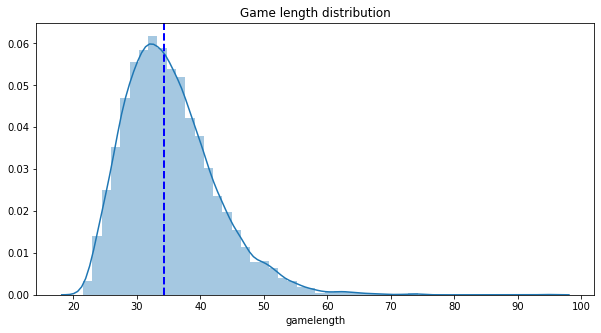

In [0]:
# Check gameLength distribution

# Teams version 3 data (Cleaned but full features) 
link = 'https://drive.google.com/open?id=1nR4ZSl0Q3VkLSCIqhaHgLfMdXEz1VOx-'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Teams.csv')  
Teams_df_full = pd.read_csv('Teams.csv')

#Histogram of game length 
plt.figure(figsize=(10,5))
sns.distplot(Teams_df_full['gamelength'])
plt.title('Game length distribution')
plt.axvline(np.median(Teams_df_full['gamelength']), color = 'b', linestyle = 'dashed', linewidth = 2) #put a vertical line in the median
ax.set_title('Game length')

Gamelength is slightly skewed to the right with a median around 33.

Text(0.5, 1.0, 'Time distribution')

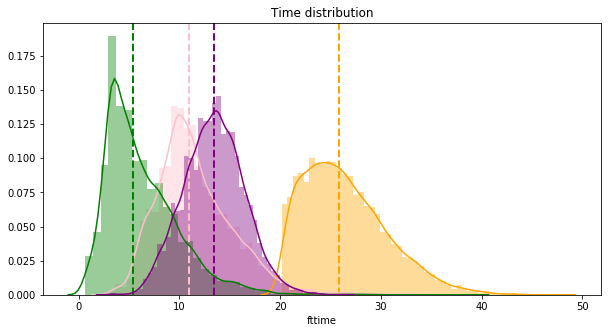

In [0]:
# Compare distributions of time
plt.figure(figsize=(10,5))
sns.distplot(Teams_df['fbarontime'],color = 'orange')
plt.title('Time')
plt.axvline(np.median(Teams_df['fbarontime']), color = 'orange', linestyle = 'dashed', linewidth = 2) #put a vertical line in the median

sns.distplot(Teams_df['fdtime'],color = 'pink')
plt.axvline(np.median(Teams_df['fdtime']), color = 'pink', linestyle = 'dashed', linewidth = 2) #put a vertical line in the median

sns.distplot(Teams_df['fbtime'],color = 'green')
plt.axvline(np.median(Teams_df['fbtime']), color = 'green', linestyle = 'dashed', linewidth = 2) #put a vertical line in the median

sns.distplot(Teams_df['fttime'],color = 'purple')
plt.axvline(np.median(Teams_df['fttime']), color = 'purple', linestyle = 'dashed', linewidth = 2) #put a vertical line in the median
plt.title('Time distribution')

It seems that first baron of game killed generally occurs at very late of the game. First turret destoryed seems to overlap with first blood time because people die from defending their towers. 

In [0]:
Teams_df.head()

,gameid,league,ban1,ban2,ban3,ban4,ban5,result,kpm,d,a,fb,fbvictim,fbtime,fd,fdtime,teamdragkills,elementals,firedrakes,waterdrakes,earthdrakes,airdrakes,elders,herald,heraldtime,ft,fttime,firstmidouter,firsttothreetowers,teamtowerkills,fbaron,fbarontime,teambaronkills,dmgtochamps,wards,wardshare,wardkills,wcpm,visionwards,visiblewardclearrate,invisiblewardclearrate,goldspent,minionkills,monsterkillsenemyjungle,goldat10,goldat15,xpat10,gdiffat10,gdiffat15
0,1002300127,NALCS,LeBlanc,Zac,Shen,Tristana,Kog'Maw,0,0.118188,18.0,2.0,1,0,6.732133,0,11.941800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,14.088500,1.0,12.368267,0.0,0.0,4.0,0.0,21.536467,0.0,32359.0,76.0,1.0,18.0,0.709127,24.0,0.571429,0.037037,39530.0,691.0,5.0,14949.0,23007.0,18625.0,-342.0,-3854.0
1,1002300127,NALCS,Caitlyn,Kalista,Thresh,Blitzcrank,Bard,1,0.709127,3.0,55.0,0,1,6.732133,1,11.941800,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,14.088500,0.0,12.368267,1.0,1.0,10.0,1.0,21.536467,1.0,54497.0,82.0,1.0,27.0,1.063690,25.0,0.653846,0.200000,45160.0,693.0,18.0,15291.0,26861.0,18807.0,342.0,3854.0
2,240145,NACS,Elise,Caitlyn,Thresh,Vladimir,Brand,1,0.554734,28.0,64.0,1,0,6.532150,0,16.393367,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,13.826250,0.0,14.792250,1.0,0.0,10.0,0.0,23.230017,2.0,142669.0,134.0,1.0,36.0,0.798817,23.0,0.538462,0.147059,80035.0,1117.0,82.0,14972.0,23524.0,17739.0,-79.0,-1283.0
3,240145,NACS,Zac,Cassiopeia,Nunu,Tristana,Viktor,0,0.621302,25.0,72.0,0,1,6.532150,1,16.393367,3.0,3.0,1.0,0.0,0.0,2.0,0.0,1.0,13.826250,1.0,14.792250,0.0,1.0,6.0,1.0,23.230017,1.0,139501.0,141.0,1.0,52.0,1.153846,33.0,0.658537,0.268817,77850.0,1080.0,82.0,15051.0,24807.0,18289.0,79.0,1283.0
4,240148,NACS,Cassiopeia,Sejuani,Blitzcrank,Lucian,Viktor,1,0.784314,2.0,35.0,1,0,5.728883,1,12.597450,2.0,2.0,0.0,0.0,1.0,1.0,0.0,1.0,16.359083,1.0,7.878567,1.0,1.0,10.0,1.0,20.965183,1.0,50721.0,68.0,1.0,14.0,0.610022,11.0,0.733333,0.071429,42430.0,665.0,33.0,17010.0,27395.0,19356.0,2154.0,4830.0


## Feature Selection

### Filter Method

#### Check for multicollinearity


In [0]:
# describe numeric variables
df = Teams_df._get_numeric_data()
df.drop(['gameid','result'], axis = 1, inplace = True)
df.describe()

,kpm,d,a,fb,fbvictim,fbtime,fd,fdtime,teamdragkills,elementals,firedrakes,waterdrakes,earthdrakes,airdrakes,elders,herald,heraldtime,ft,fttime,firstmidouter,firsttothreetowers,teamtowerkills,fbaron,fbarontime,teambaronkills,dmgtochamps,wards,wardshare,wardkills,wcpm,visionwards,visiblewardclearrate,invisiblewardclearrate,goldspent,minionkills,monsterkillsenemyjungle,goldat10,goldat15,xpat10,gdiffat10,gdiffat15
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.0,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,0.334197,11.594158,27.412732,0.500000,0.500000,6.286012,0.500000,11.540198,1.889859,1.758405,0.456642,0.436065,0.437075,0.428624,0.131913,0.208157,11.323619,0.500000,13.411085,0.500000,0.500000,6.188499,0.500000,26.437631,0.775951,66337.856421,131.381775,1.0,52.744075,1.466623,40.963256,0.569620,0.285404,58249.460959,973.793588,31.267591,15347.578725,24082.354951,18544.972258,0.000000,0.000000
std,0.191879,6.344490,16.273141,0.500023,0.500023,3.639906,0.500023,3.858722,1.397713,1.299115,0.707401,0.704275,0.688137,0.686643,0.379852,0.744313,6.042725,0.500023,2.975882,0.500023,0.500023,3.847163,0.500023,4.137606,0.792161,26629.179770,40.471722,0.0,21.570670,0.419580,13.977498,0.124763,0.086592,13869.012637,214.616816,28.778692,835.701272,1546.518638,798.471012,1254.334726,2477.260084
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.647783,0.000000,2.980533,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,3.242333,0.000000,0.000000,0.000000,0.000000,20.161783,0.000000,14879.000000,49.000000,1.0,10.000000,0.331658,9.000000,0.171429,0.021277,27900.000000,473.000000,0.000000,12737.000000,19336.000000,14456.000000,-6674.000000,-10163.000000
25%,0.188932,7.000000,14.000000,0.000000,0.000000,3.570342,0.000000,8.994242,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.735096,0.000000,11.347387,0.000000,0.000000,2.000000,0.000000,23.231917,0.000000,47879.750000,103.000000,1.0,37.000000,1.179158,31.000000,0.483871,0.226247,48633.000000,822.000000,9.000000,14773.000000,22987.000000,18056.250000,-766.000000,-1619.000000
50%,0.311468,11.000000,26.000000,0.500000,0.500000,5.386667,0.500000,10.925717,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.686600,0.500000,13.437567,0.500000,0.500000,7.000000,0.500000,25.817633,1.000000,61685.000000,125.000000,1.0,50.000000,1.422803,40.000000,0.571429,0.282609,56733.000000,951.000000,23.000000,15266.000000,23918.000000,18592.000000,0.000000,0.000000
75%,0.449316,16.000000,39.000000,1.000000,1.000000,8.194067,1.000000,13.630425,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,15.424238,1.000000,15.389329,1.000000,1.000000,10.000000,1.000000,28.972817,1.000000,79770.750000,153.000000,1.0,64.000000,1.702985,49.000000,0.654762,0.340909,65806.000000,1094.000000,47.000000,15838.000000,25005.750000,19097.000000,766.000000,1619.000000
max,1.818182,56.000000,111.000000,1.000000,1.000000,38.991433,1.000000,33.899450,8.000000,6.000000,3.000000,3.000000,3.000000,3.000000,5.000000,1.000000,19.918567,1.000000,25.894900,1.000000,1.000000,11.000000,1.000000,47.260500,6.000000,239076.000000,484.000000,1.0,233.000000,3.667377,115.000000,2.282051,1.000000,209091.000000,3188.000000,181.000000,21281.000000,32997.000000,21258.000000,6674.000000,10163.000000


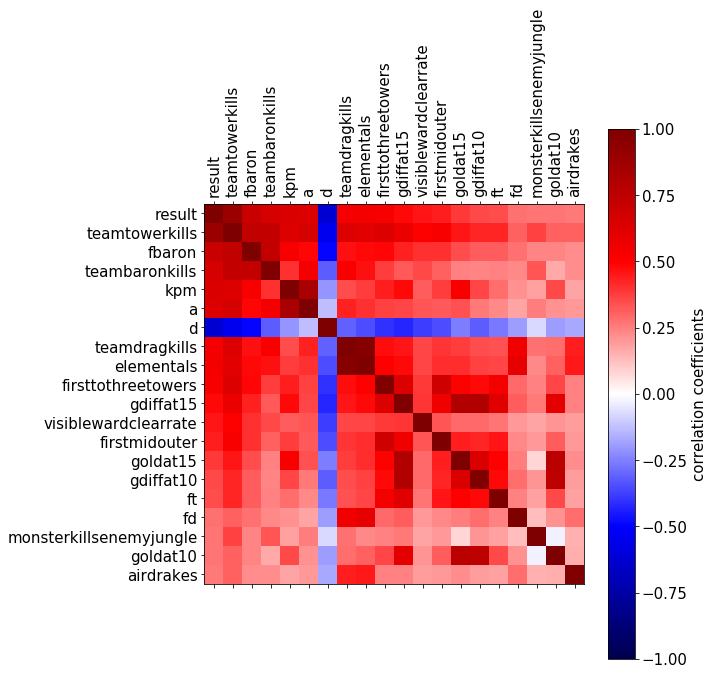

43


In [0]:
# method for correlation used here is spearman since there are categorical and numerical variables here
corr_matrix = (Teams_df.corr(method="spearman"))
# visualize result from spearman corr
all_cols = np.abs(corr_matrix).sort_values('result',ascending=False)['result'].index 
cols = all_cols[:20] # positively correlated features

cm = corr_matrix.loc[cols,cols]

plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10,10))
plt.matshow(cm,vmin=-1,vmax=1,cmap='seismic',fignum=0)
plt.colorbar(label='correlation coefficients')
plt.xticks(np.arange(cm.shape[0]),list(cols),rotation=90)
plt.yticks(np.arange(cm.shape[0]),list(cols))
plt.tight_layout()
plt.show()
print(corr_matrix.shape[0])

This correlation heatmap shows two important pieces of information: it shows the top 20 highly related variables and how these variables correlate to 'result'. 

#### Drop Columns Based on Correlation Values

In [0]:
# due to symmetrical marix, we generate a triangle side of correlation matrix (upper) without diagonal (k=1)
corr_values = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))).stack()
# Sort the correlation values by highest to lowest
corr_values = (corr_values.sort_values(ascending=False))
# display correlations above 70%
corr_values[corr_values > 0.7]

teamdragkills   elementals        0.962533
goldspent       minionkills       0.884051
result          teamtowerkills    0.883560
wardkills       wcpm              0.876037
wards           minionkills       0.841920
kpm             a                 0.825482
dmgtochamps     goldspent         0.823371
wardkills       minionkills       0.806873
wards           goldspent         0.803362
goldat15        gdiffat15         0.800915
gdiffat10       gdiffat15         0.798202
wards           wardkills         0.792248
goldat10        goldat15          0.764929
                gdiffat10         0.750468
wardkills       goldspent         0.741932
teamtowerkills  fbaron            0.737709
herald          heraldtime        0.734827
fbaron          teambaronkills    0.733266
teamtowerkills  teambaronkills    0.727938
result          fbaron            0.705677
dtype: float64

From the list of highly correlated features, we can remove some of them:
* teamdragkills and elementals (will check with other feature selection methods to decide which to be removed) 
* wardskills, wcpm, wards, visionwards (will check with other selection methods to decide which to be removed but wards seems to be highly correlated with other features)
* gold spent (can be represented by goldat10/15 or gold difference at 10/15 depending on other feature selection methods)
* kpm and a (will check with other selection methods to decide which to be removed)
* teambaronkills (can be represented by baron kill time or first baron killed depending on other selection methods)


In [0]:
# calling categorical variables
categoricalcols = Teams_df.select_dtypes(include=['object','category'])
print(categoricalcols.columns)

# calling variables with 2 (dummy) or 3 unique values
factorvariables = []
for i in Teams_df.columns:
    if Teams_df[i].nunique() <= 3:
        factorvariables.append(i)
factorvariables.remove('result')
factorvariables.remove('wardshare') # not categorical
print(factorvariables)

# convert dummy variables to categorical variables
Teams_df_new = Teams_df
Teams_df_new[factorvariables] = Teams_df[factorvariables].apply(lambda x:x.astype('category'),axis=0)
print(Teams_df_new[factorvariables].dtypes)

Index(['league', 'ban1', 'ban2', 'ban3', 'ban4', 'ban5'], dtype='object')
['fb', 'fbvictim', 'fd', 'herald', 'ft', 'firstmidouter', 'firsttothreetowers', 'fbaron']
fb                    category
fbvictim              category
fd                    category
herald                category
ft                    category
firstmidouter         category
firsttothreetowers    category
fbaron                category
dtype: object


In [0]:
# drop the categorical variables that are not used in prediction
X = Teams_df_new.drop(['league', 'ban1', 'ban2', 'ban3', 'ban4', 'ban5',
                   'gameid','result'], inplace= False, axis = 1)
Y = Teams_df_new['result']

### Apply sequential feature selection to identify important predictors

Sequential feature selection algorithms are a family of greedy search algorithms that are used to reduce an initial d-dimensional feature space to a k-dimensional feature subspace where k < d. The motivation behind feature selection algorithms is to automatically select a subset of features that is most relevant to the problem. The goal of feature selection is two-fold: We want to improve the computational efficiency and reduce the generalization error of the model by removing irrelevant features or noise. A wrapper approach such as sequential feature selection is especially useful if embedded feature selection -- for example, a regularization penalty like LASSO -- is not applicable.

In a nutshell, SFAs remove or add one feature at the time based on the classifier performance until a feature subset of the desired size k is reached.

Four sequential feature selections that we will use here are:
1. Sequential Forward Selection
2. Sequential Backward Selection
3. Sequential Forward Floating Selection
4. Sequential Backward Floating Selection

#### Sequential Forward Selection (SFS)

In [0]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression

# use logistic regression as base classifier 
sfs_forward = SFS(LogisticRegression(C=1000, solver='liblinear', random_state=23),
           k_features = 10, verbose=0, scoring='accuracy',
           forward = True,cv = 3) #3 fold cross validation, select top 10 features, Logistic Regression Classifier

sfs_forward.fit(X.to_numpy(),Y, custom_feature_names=X.columns)
SFS_featuresselected = sfs_forward.k_feature_names_
print(SFS_featuresselected)
print(sfs_forward.k_score_)

('kpm', 'd', 'waterdrakes', 'ft', 'firstmidouter', 'firsttothreetowers', 'teamtowerkills', 'fbarontime', 'wardkills', 'wcpm')
0.9783208450142399


Accuracy of model show that 10 features are enough to provide for high accuracy in prediction as it can represent 97% of the data.

#### Sequential Backward Selection (SBS)

In [0]:
sbs_backward = SFS(LogisticRegression(C=1000, solver='liblinear', random_state=23),
           k_features = 10, verbose=0, scoring='accuracy',
           forward = False,cv = 3)  #3 fold cross validation, select top 10 features, Logistic Regression Classifier
sbs_backward.fit(X.to_numpy(),Y, custom_feature_names=X.columns)
SBS_featuresselected = sbs_backward.k_feature_names_
print(SBS_featuresselected)
print(sbs_backward.k_score_)

('d', 'a', 'teamtowerkills', 'fbarontime', 'teambaronkills', 'goldspent', 'minionkills', 'xpat10', 'gdiffat10', 'gdiffat15')
0.9796994197765972


Accuracy of model show that 10 features are enough to provide for high accuracy in prediction as it can represents 98% of the data.

#### Sequential Forward Floating Selection (SFFS)

The floating variants, SFFS and SBFS, can be considered as extensions to the simpler SFS and SBS algorithms. The floating algorithms have an additional exclusion or inclusion step to remove features once they were included (or excluded), so that a larger number of feature subset combinations can be sampled. It is important to emphasize that this step is conditional and only occurs if the resulting feature subset is assessed as "better" by the criterion function (i.e. accuracy in our case) after removal (or addition) of a particular feature. 

In [0]:
sffs = SFS(LogisticRegression(C=1000, solver='liblinear', random_state=23),
           k_features = 10, verbose=0, scoring='accuracy',
           forward = True,floating = True,cv = 3) #3 fold cross validation, select top 10 features, Logistic Regression Classifier

sffs.fit(X.to_numpy(),Y, custom_feature_names=X.columns)
SFFS_featuresselected = sffs.k_feature_names_
print(SFFS_featuresselected)
print(sffs.k_score_)

('kpm', 'd', 'waterdrakes', 'ft', 'firstmidouter', 'firsttothreetowers', 'teamtowerkills', 'fbarontime', 'wardkills', 'wcpm')
0.9783208450142399


#### Sequential Backward Floating Selection(SBFS)

In [0]:
sbfs = SFS(LogisticRegression(C=1000, solver='liblinear', random_state=23),
           k_features = 10, verbose=0, scoring='accuracy',
           forward = False,floating = True,cv = 3) #3 fold cross validation, select top 10 features, Logistic Regression Classifier

sbfs.fit(X.to_numpy(),Y, custom_feature_names=X.columns)
SBFS_featuresselected = sbfs.k_feature_names_
print(SBFS_featuresselected)
print(sbfs.k_score_)

('d', 'a', 'elementals', 'teamtowerkills', 'fbarontime', 'teambaronkills', 'goldspent', 'minionkills', 'xpat10', 'gdiffat10')
0.9798831251271864


#### Comparison Between SFS, SBS, SFFS & SBFS

In [0]:
print('\nSequential Forward Selection (k=10 & cv=3):')
print(SFS_featuresselected)
print('CV Score:')
print(sfs_forward.k_score_)

print('\nSequential Backward Selection (k=10 & cv=3):')
print(SBS_featuresselected)
print('CV Score:')
print(sbs_backward.k_score_)

print('\nSequential Forward Floating Selection (k=10 & cv=3):')
print(SFFS_featuresselected)
print('CV Score:')
print(sffs.k_score_)

print('\nSequential Backward Floating Selection (k=10 & cv=3):')
print(SBFS_featuresselected)
print('CV Score:')
print(sbfs.k_score_)

print('\nSimilar features in SFS, SBS, SFFS, & SBFS:')
#intersection of similar features
for i in sfs_forward.k_feature_names_:
  if i in sbs_backward.k_feature_names_:
    if i in sffs.k_feature_names_:
      if i in sbfs.k_feature_names_:
        print(i)


Sequential Forward Selection (k=10 & cv=3):
('kpm', 'd', 'waterdrakes', 'ft', 'firstmidouter', 'firsttothreetowers', 'teamtowerkills', 'fbarontime', 'wardkills', 'wcpm')
CV Score:
0.9783208450142399

Sequential Backward Selection (k=10 & cv=3):
('d', 'a', 'teamtowerkills', 'fbarontime', 'teambaronkills', 'goldspent', 'minionkills', 'xpat10', 'gdiffat10', 'gdiffat15')
CV Score:
0.9796994197765972

Sequential Forward Floating Selection (k=10 & cv=3):
('kpm', 'd', 'waterdrakes', 'ft', 'firstmidouter', 'firsttothreetowers', 'teamtowerkills', 'fbarontime', 'wardkills', 'wcpm')
CV Score:
0.9783208450142399

Sequential Backward Floating Selection (k=10 & cv=3):
('d', 'a', 'elementals', 'teamtowerkills', 'fbarontime', 'teambaronkills', 'goldspent', 'minionkills', 'xpat10', 'gdiffat10')
CV Score:
0.9798831251271864

Similar features in SFS, SBS, SFFS, & SBFS:
d
teamtowerkills
fbarontime


**Observation**:
Sequential selections and sequential floating selections generated similar functions. It shows that while floating method takes a extra step, which is to remove the included feature (for forward selection) to include back the removed feature (for backward selection) to maximize accuracy, the accuracy has reached its maximum.  

### Comparing sequential selection with regularized and tree methods in Sklearn module 

Regularisation consists in adding a penalty to the different parameters of the machine learning model to reduce the freedom of the model and in other words to avoid overfitting. In linear model regularisation, the penalty is applied over the coefficients that multiply each of the predictors. From the different types of regularisation, Lasso or L1 has the property that is able to shrink some of the coefficients to zero. Therefore, that feature can be removed from the model.

Features will be scaled as linear models benefits from it

In [0]:
scaler = StandardScaler()
scaler.fit(X)

StandardScaler(copy=True, with_mean=True, with_std=True)

#### Selecting features using Lasso regularisation from SelectFromModel and Logistic

Feature selection here will be done using Logistic Regression with Lasso (L1) penalty to focus on coefficients that are non-zeros

In [0]:
l1selection = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))
l1selection.fit(scaler.transform(X), Y)

SelectFromModel(estimator=LogisticRegression(C=1, class_weight=None, dual=False,
                                             fit_intercept=True,
                                             intercept_scaling=1, l1_ratio=None,
                                             max_iter=100, multi_class='warn',
                                             n_jobs=None, penalty='l1',
                                             random_state=None,
                                             solver='liblinear', tol=0.0001,
                                             verbose=0, warm_start=False),
                max_features=None, norm_order=1, prefit=False, threshold=None)

In [0]:
# get list of selected features
lasso1_selection = X.columns[(l1selection.get_support())]
print('total features: {}'.format((X.shape[1])))
print('selected features: {}'.format((lasso1_selection)))
# Find feature that were regularized
print('features with coefficients shrank to zero: {}'.format(
     X.columns[(l1selection.estimator_.coef_ == 0).ravel().tolist()]))

total features: 41
selected features: Index(['kpm', 'd', 'a', 'fb', 'fbvictim', 'fbtime', 'fd', 'firedrakes',
       'waterdrakes', 'earthdrakes', 'airdrakes', 'elders', 'herald',
       'heraldtime', 'ft', 'fttime', 'firstmidouter', 'firsttothreetowers',
       'teamtowerkills', 'fbaron', 'fbarontime', 'teambaronkills',
       'dmgtochamps', 'wards', 'wardkills', 'wcpm', 'visionwards',
       'visiblewardclearrate', 'invisiblewardclearrate', 'goldspent',
       'minionkills', 'monsterkillsenemyjungle', 'goldat10', 'goldat15',
       'xpat10', 'gdiffat10', 'gdiffat15'],
      dtype='object')
features with coefficients shrank to zero: Index(['fdtime', 'teamdragkills', 'elementals', 'wardshare'], dtype='object')


#### Selecting features using Tree Model from SelectFromModel and ExtraForest Classifier

Extremely Randomized Trees Classifier (Extra Tree) is an ensemble learning method fundamentally based on decision trees. It is like RandomForest, which randomizes certain decisions and subsets of data to minimize over-learning from the data and overfitting.

Feature selection using Extra Tree comes under the category of Embedded methods. Embedded methods combine the qualities of filter and wrapper methods.

Each Decision Tree in the Extra Tree is constructed from the original training sample. Then, at each test node, Each tree is provided with a random sample of k features from the feature-set from which each decision tree must select the best feature to split the data based on some impurity criteria (typically the Gini Index). 

The more a feature decreases the impurity, the more important the feature is. In random forests, the impurity decrease from each feature can be averaged across trees to determine the final importance of the variable.

Features that are selected at the top of the trees are in general more important than features that are selected at the end nodes of the trees, as generally the top splits lead to bigger information gains.



In [0]:
extratree = ExtraTreesClassifier(n_estimators=50)
extratree.fit(X,Y)
# Computing the importance of each feature 
tree_features =  extratree.feature_importances_

# Normalizing the individual importances 
feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                        extratree.estimators_], 
                                        axis = 0)

tree_featureslist = pd.DataFrame({'Features':X.columns,
                                  'Importance': feature_importance_normalized})

filtered_tree_features = tree_featureslist.sort_values(by=['Importance'], 
                                                       ascending=False).head(15)
                                                  
print(filtered_tree_features)

                   Features  Importance
21           teamtowerkills    0.203346
22                   fbaron    0.175850
24           teambaronkills    0.095327
20       firsttothreetowers    0.087636
19            firstmidouter    0.065803
2                         a    0.062045
9                elementals    0.044264
0                       kpm    0.041734
17                       ft    0.032243
1                         d    0.029977
40                gdiffat15    0.026081
6                        fd    0.024156
35  monsterkillsenemyjungle    0.020896
31     visiblewardclearrate    0.018481
8             teamdragkills    0.012968


### Features selected by all the methods of feature selection applied

In [0]:
pd.DataFrame.from_dict({
    'SFS_features'       : SFS_featuresselected,
    'SBS features'       : SBS_featuresselected, 
    'SFFS features'      : SFFS_featuresselected,
    'SBFS features'      : SBFS_featuresselected,
    'Lasso L1 penalty'   : lasso1_selection[:15], 
    'Tree top features'  : filtered_tree_features['Features']
}, orient='index').T

,SFS_features,SBS features,SFFS features,SBFS features,Lasso L1 penalty,Tree top features
0,kpm,d,kpm,d,kpm,teamtowerkills
1,d,a,d,a,d,fbaron
2,waterdrakes,teamtowerkills,waterdrakes,elementals,a,teambaronkills
3,ft,fbarontime,ft,teamtowerkills,fb,firsttothreetowers
4,firstmidouter,teambaronkills,firstmidouter,fbarontime,fbvictim,firstmidouter
5,firsttothreetowers,goldspent,firsttothreetowers,teambaronkills,fbtime,a
6,teamtowerkills,minionkills,teamtowerkills,goldspent,fd,elementals
7,fbarontime,xpat10,fbarontime,minionkills,firedrakes,kpm
8,wardkills,gdiffat10,wardkills,xpat10,waterdrakes,ft
9,wcpm,gdiffat15,wcpm,gdiffat10,earthdrakes,d


### Final variables selected

To get predictors most frequently identified by all feature selection methods as well as take into considered predictors that have less correlated variables (less than correlation coefficient less than 0.7) below. 

Following are the features selected twice of more by the 6 methods applied above: 
1. d (death)
2. kpm (kills per minute) 
3. a (assist) - highly correlated to kpm
4. ft (first turret/tower) 
5. teamtowerkills 
6. fbarontime (time to kill fbaron)
7. waterdrakes (how many times this dragon was killed)- however, this may not appear in every game
8. firstmidouter (first team to destroy mid outer tower) - same category as teamtowerkills 
9. firsttothreetowers (first team to destroy three towers) - same category as teamtowerkils
10. elementals (total elementals killed)
11. wardkills (number of wards destoryed) - highly correlated with minionkills
12. wcpm (total wards cleared/killed per minute)
13. goldspent - highly correlated with minionkills
14. minionkills (number of minions killed) 
15. xpat10 (total experience gained by all champions in the team at 10 minutes)
16. gdiffat10 (gold difference at 10 minutes)- highly correlated with gdiffat 15
17. gdiffat15 (gold difference at 15 minutes)
 

To avoid multicolinearity of predictors, we will further filter the features as well as merge features that fall under the same category:
- feature 'a' (assist) will be removed as it is highly correlated with kpm
- feature 'waterdrakes' does not always appear in the game so a more general feature 'elementals' is more applicable 
-  feature 'firstmidouter' and 'firsttothreetowers' are under the same category of towers so they will be captured by a more frequently selected variable (i.e. teamtowerkills)
- feature 'wardkills' (total wards destroyed) will be removed as it is highly correlated with feature 'minionkills'
- feature 'goldspent' will be removed as it is highly correlated with minionkills, gdiffat10 and gdiffat15
- feature 'gdiffat10' will be removed as it is highly correlated with gdiffat 15 and gold difference at 15 minutes makes more impact to the match than 10 minutes

Lastly, sequential selections have shown us that 10 variables are sufficient to achieve high model accuracy (this is also supported by knowledge domain perspective). 

Based on the above, these are the final variables:
1. Number of deaths during the match (d)
2. Kills per minute (kpm)
3. First turret (ft)
4. Total towers destroyed (teamtowerkills)
5. Time to kill baron (fbarontime)
6. Total elemental dragons killed (elementals)
7. Wards destoryed by team (wardkills)
8. Total minions killed by team (minionkills)
9. XP gained at 10 minutes (xpat10)
10. Gold difference between teams at 15 min (gdifft15)


[Text(0, 0.5, 'd'),
 Text(0, 1.5, 'kpm'),
 Text(0, 2.5, 'ft'),
 Text(0, 3.5, 'teamtowerkills'),
 Text(0, 4.5, 'fbarontime'),
 Text(0, 5.5, 'elementals'),
 Text(0, 6.5, 'wcpm'),
 Text(0, 7.5, 'minionkills'),
 Text(0, 8.5, 'xpat10'),
 Text(0, 9.5, 'gdiffat15')]

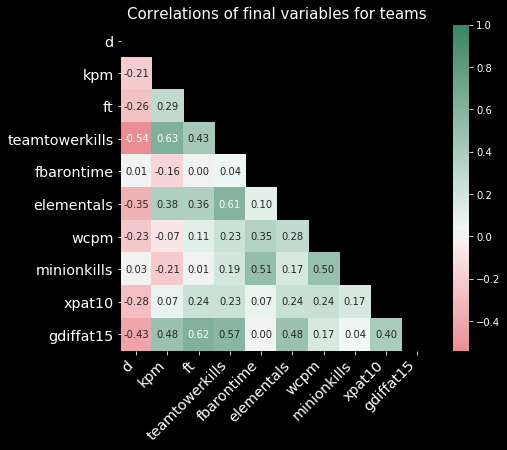

In [0]:
features_selected = ['d','kpm','ft','teamtowerkills','fbarontime',
            'elementals','wcpm','minionkills','xpat10','gdiffat15']

plt.style.use('dark_background')

df_corr = Teams_df[features_selected]
m = np.zeros_like(df_corr.corr(method = 'pearson'), dtype=np.bool)
m[np.triu_indices_from(m)] = True
cmap = sns.diverging_palette(10, 150, as_cmap=True)

plt.figure(figsize = (7,6))
chart = sns.heatmap(df_corr.corr(), cmap = cmap, annot = True, fmt = '.2f', mask = m, center = 0,linecolor=None)
plt.title('Correlations of final variables for teams', fontsize=15)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45,horizontalalignment='right',fontweight='light',
    fontsize='x-large')
chart.set_yticklabels(chart.get_yticklabels(), fontweight='light',fontsize='x-large')

## Visualizing to 10 variables selected for prediction models

In [0]:
categories = Teams_df['result'].unique()

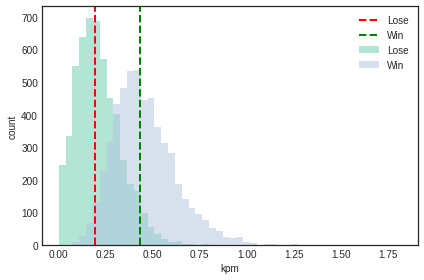

In [0]:
# Compare kpm between winning/losing teams
plt.style.use('seaborn-white')
bin_range = (Teams_df['kpm'].min(),Teams_df['kpm'].max())
color = ['mediumaquamarine','lightsteelblue']

for c in categories:
    plt.hist(Teams_df[Teams_df['result']==c]['kpm'],alpha=0.5,label=c,range=bin_range,bins=50,color=color[c])
plt.ylabel('count')
plt.xlabel('kpm')
plt.tight_layout()
plt.axvline(np.median(Teams_df['kpm'][Teams_df['result']==0]), color = 'r', linestyle = 'dashed', linewidth = 2)
plt.axvline(np.median(Teams_df['kpm'][Teams_df['result']==1]), color = 'g', linestyle = 'dashed', linewidth = 2)
plt.legend(['Lose','Win','Lose','Win'])
plt.show();

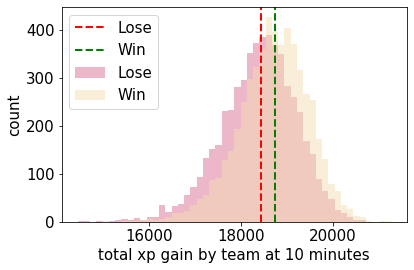

In [0]:
# Compare total xp gained at 10 minutes between winning/losing teams
bin_range = (Teams_df['xpat10'].min(),Teams_df['xpat10'].max())
color = ['palevioletred','wheat']
for c in categories:
    plt.hist(Teams_df[Teams_df['result']==c]['xpat10'],alpha=0.5,label=c,range=bin_range,bins=50, color = color[c])
plt.legend()
plt.ylabel('count')
plt.xlabel('total xp gain by team at 10 minutes')
plt.tight_layout()
plt.axvline(np.median(Teams_df['xpat10'][Teams_df['result']==0]), color = 'r', linestyle = 'dashed', linewidth = 2)
plt.axvline(np.median(Teams_df['xpat10'][Teams_df['result']==1]), color = 'g', linestyle = 'dashed', linewidth = 2)
plt.legend(['Lose','Win','Lose','Win'])
plt.show()

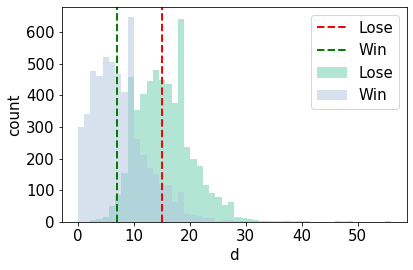

In [0]:
# comparing total deaths for winning and losing teams

bin_range = (Teams_df['d'].min(),Teams_df['d'].max())
color = ['mediumaquamarine','lightsteelblue']
for c in categories:
    plt.hist(Teams_df[Teams_df['result']==c]['d'],alpha=0.5,label=c,range=bin_range,bins=50,color = color[c])
plt.ylabel('count')
plt.xlabel('d')
plt.tight_layout()
plt.axvline(np.median(Teams_df['d'][Teams_df['result']==0]), color = 'r', linestyle = 'dashed', linewidth = 2)
plt.axvline(np.median(Teams_df['d'][Teams_df['result']==1]), color = 'g', linestyle = 'dashed', linewidth = 2)
plt.legend(['Lose','Win','Lose','Win'])
plt.show();

<Figure size 360x216 with 0 Axes>

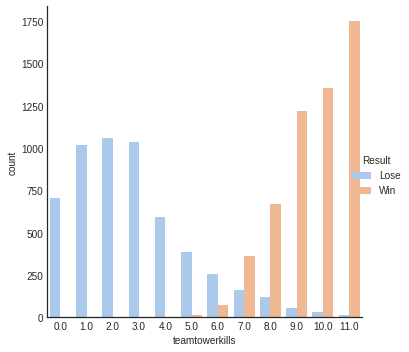

In [0]:
# compare total towers killed by winning and losing team
plt.style.use('seaborn-white')
plt.figure(figsize = (5,3))
g = sns.catplot(x="teamtowerkills", kind="count", hue = 'result', palette="pastel", data=Teams_df)
legend = g._legend
legend.set_title("Result")
for t, l in zip(legend.texts,("Lose", "Win")):
    t.set_text(l)

Text(0.5, 1, 'First Baron')

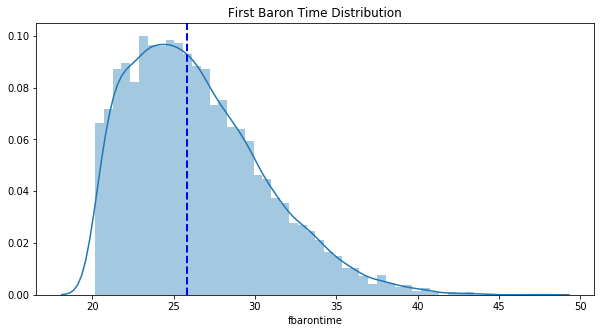

In [0]:
#Histogram of fbarontime. Note: fbarontime is the same for both teams in a game.
plt.figure(figsize=(10,5))
sns.distplot(Teams_df['fbarontime'])
plt.title('First Baron Time Distribution')
plt.axvline(np.median(Teams_df['fbarontime']), color = 'b', linestyle = 'dashed', linewidth = 2) #put a vertical line in the median
ax.set_title('First Baron')

It seems like the timing of when fbaron is killed has a greater effect on both winning and losing time than which team killed the fbaron. Baron is the most powerful monster in the match. Killing this monster grants the buff to the living members of the team, granting a large amount of attack damage and ability power as well as dramatically enhancing the power of nearby allied minions. However, the buff will not fall to the members who were killed when baron is killed

In [0]:
# Compare fbarontime for winning and losing team
Teams_df.groupby(['result','fbaron']).mean()['fbarontime']

result  fbaron
0       0.0       26.354961
        1.0       26.916724
1       0.0       26.916724
        1.0       26.354961
Name: fbarontime, dtype: float64

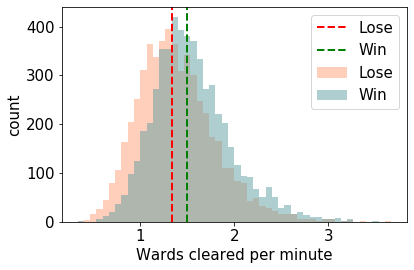

In [0]:
# compare wards cleared per minute by winning and losing team

bin_range = (Teams_df['wcpm'].min(),Teams_df['wcpm'].max())
color = ['lightsalmon','cadetblue']
for c in categories:
    plt.hist(Teams_df[Teams_df['result']==c]['wcpm'],alpha=0.5,label=c,range=bin_range,bins=50,color = color[c])
plt.ylabel('count')
plt.xlabel('Wards cleared per minute')
plt.tight_layout()
plt.axvline(np.median(Teams_df['wcpm'][Teams_df['result']==0]), color = 'r', linestyle = 'dashed', linewidth = 2)
plt.axvline(np.median(Teams_df['wcpm'][Teams_df['result']==1]), color = 'g', linestyle = 'dashed', linewidth = 2)
plt.legend(['Lose','Win','Lose','Win'])
plt.show();

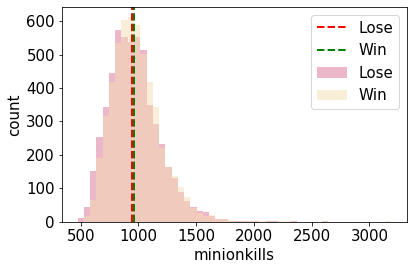

In [0]:
# compare minions killed by winning and losing team

bin_range = (Teams_df['minionkills'].min(),Teams_df['minionkills'].max())
color = ['palevioletred','wheat']
for c in categories:
    plt.hist(Teams_df[Teams_df['result']==c]['minionkills'],alpha=0.5,label=c,range=bin_range,bins=50,color = color[c])
plt.ylabel('count')
plt.xlabel('minionkills')
plt.tight_layout()
plt.axvline(np.median(Teams_df['minionkills'][Teams_df['result']==0]), color = 'r', linestyle = 'dashed', linewidth = 2)
plt.axvline(np.median(Teams_df['minionkills'][Teams_df['result']==1]), color = 'g', linestyle = 'dashed', linewidth = 2)
plt.legend(['Lose','Win','Lose','Win'])
plt.show();

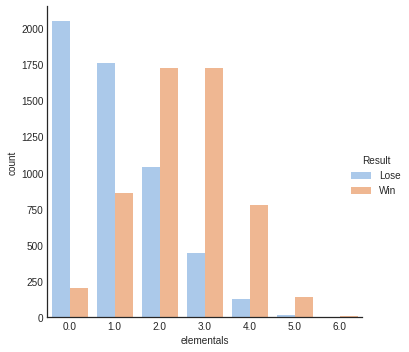

In [0]:
# compare total elemntals killed by winning and losing team

g = sns.catplot(x="elementals", kind="count", hue = 'result', palette="pastel", data=Teams_df)
legend = g._legend
legend.set_title("Result")
for t, l in zip(legend.texts,("Lose", "Win")):
    t.set_text(l)

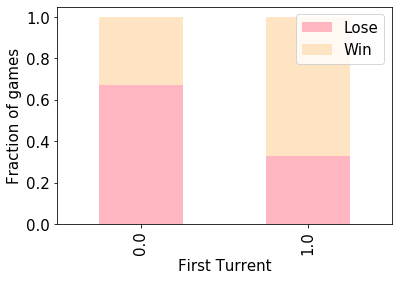

In [0]:
# Compare first turret for winning and losing team
count_matrix = Teams_df.groupby(['ft', 'result']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis = 1), axis = 0)
count_matrix_norm.plot(kind = 'bar', stacked = True, color = ['lightpink','bisque'])
plt.legend(loc = 3)
plt.legend(['Lose','Win'])
plt.xlabel('First Turret')
plt.ylabel('Fraction of games')
plt.show()

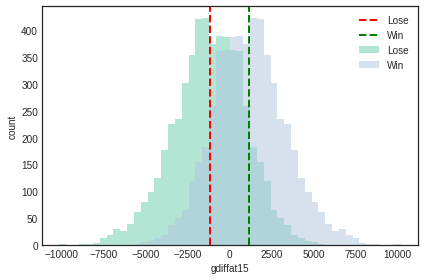

In [0]:
# compare gdiffat15 for winning and losing teams
bin_range = (Teams_df['gdiffat15'].min(),Teams_df['gdiffat15'].max())
color = ['mediumaquamarine','lightsteelblue']
for c in categories:
    plt.hist(Teams_df[Teams_df['result']==c]['gdiffat15'],alpha=0.5,label=c,range=bin_range,bins=50,color = color[c])
plt.ylabel('count')
plt.xlabel('gdiffat15')
plt.tight_layout()
plt.axvline(np.median(Teams_df['gdiffat15'][Teams_df['result']==0]), color = 'r', linestyle = 'dashed', linewidth = 2)
plt.axvline(np.median(Teams_df['gdiffat15'][Teams_df['result']==1]), color = 'g', linestyle = 'dashed', linewidth = 2)
plt.legend(['Lose','Win','Lose','Win'])
plt.show();